#Ambrose Desmond MSC_DA_CA2

## Irelands Dairy sector analysis compared to the top EU producer and global producers.

In [521]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import statistics as stats
from scipy.stats import poisson
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import warnings
from sklearn.feature_selection import RFE
import json
import requests
import time
# from faker import Factory,Faker
warnings.filterwarnings('ignore') # supress warnings

In [522]:
# Function to convert the astype of given colums

def astype_change(df,convert):
    """Function to change the astype of a given dataframe using a conversion dictionary"""
    df = df.astype(convert)
    return df
# conversion dictionart with key,  value pairs of Column name : astype I want to convert to
# convert_dict = {'column_name': astype, ect}
# calling the function and passing in the dataframe and dictionary
# datasframe = astype_change(dataframe,convert_dict)

In [523]:
# A function to strip spaces and ',' from a given string . look for use in read_cvs converters parameters.
def strip_spaces(a_str_with_spaces):
    """Function to strip white spaces from a give string"""
    # replaces ' 'space with '' no space
    a_str_with_spaces.replace(' ', '')
    a_str_with_spaces.replace(',', '')
    
    return a_str_with_spaces

#pandas.read_csv(..., converters={'employee_id': strip_spaces})

In [524]:
# pip install pyspellchecker

In [525]:

from spellchecker import SpellChecker
spell = SpellChecker(language='en',distance=1)

def correct(x):
    return spell.correction(x)
#pandas.read_csv(..., converters={'date': correct})

# EDA on Irish Milk production
## with emphisis on fat and protine content of milk 
## by month

In [526]:
# Import the dairy csv as ddf
ddf = pd.read_csv("IE_Intake of Cows Milk by Creameries and Pasteurisers.csv")

In [527]:
# Check The shape
ddf.shape

(575, 4)

In [528]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0                                          575 non-null    object 
 1   Intake of Cows Milk by Creameries and Pasteurisers  574 non-null    object 
 2   Fat Content                                         514 non-null    float64
 3   Protein Content                                     514 non-null    float64
dtypes: float64(2), object(2)
memory usage: 18.1+ KB


In [529]:
ddf.head()

,Unnamed: 0,Intake of Cows Milk by Creameries and Pasteurisers,Fat Content,Protein Content
0,"Source: Central Statistics Office, Ireland.",NaN,NaN,NaN
1,1975 January,55.8,NaN,NaN
2,1975 February,84.4,NaN,NaN
3,1975 March,193.3,NaN,NaN
4,1975 April,327.5,NaN,NaN


In [530]:
# need to drop the first row as its not part of the actual data.
ddf.drop(index=ddf.index[0], axis=0, inplace=True)
# alternativaly i could have used ddf.iloc[1:] to select everything except the first row and 
# and store it in a new dataframe. here I chose to use the drop() function with index 0 ( ie first line) the axis 0 indicates row
# and inplace = true performs the operation to the existing  dataframe. I chose this because It saves space to 
# edit the existing dataframe instead of creating new ones which the other methods do.

In [531]:
# formatt the data to give concise and meaningfull headings to the dataframe,
# I did this because it will make reading the dataframe easier for myself and other people looking at it

ddf.columns = ['date','milk','fat','pro']
ddf.head()
# note nan value here are fat and protine not recorded in the early records

,date,milk,fat,pro
1,1975 January,55.8,NaN,NaN
2,1975 February,84.4,NaN,NaN
3,1975 March,193.3,NaN,NaN
4,1975 April,327.5,NaN,NaN
5,1975 May,493.5,NaN,NaN


In [532]:
# Im spliting out a Month and  Year column from date using a lanbda function
# because I will be using month to group my data later on.
ddf[['year','month']] = ddf.date.apply(lambda x: pd.Series(str(x).split(" ")))

In [533]:
#I want to convert date string  colum to datetime object because datetime objects are easier to manipulate
# espically if the date is in the index. there is dedicated functionality with date time objects.
ddf[["date"]] = ddf[["date"]].apply(pd.to_datetime)
# my .info() on the dataframe revealed the milk colum is type object. I want to converted this to float type 
# because this data type is best interpertiped numerically for manipulation in charts and models.
#  My inital attempt of ddf['milk'] = ddf['milk'].astype(float)
# got an error trying to convert str to float ValueError: could not convert string to float: '1,072.2'
# the problem here is the comma seperasting thousands , need to strip these out and try again.
# Im using a lambda function on the milk column to strip the comma .
# I chose to use lambda because its a singl euse function that saves time and space v writing a dedicated function.
ddf['milk'] = ddf['milk'].apply(lambda x : x.replace(',',''))
ddf['milk'] = ddf['milk'].astype(float)

In [534]:
# Selecting the last 10 years of data.This will conviently remove the dates where fat and pro data
# was not being collected.

ddfd = ddf[(ddf['date'] >= '2012-01-01')]
ddfd.tail()

,date,milk,fat,pro,year,month
570,2022-06-01,1057.60,4.00,3.47,2022,June
571,2022-07-01,1022.80,4.03,3.47,2022,July
572,2022-08-01,919.01,4.21,3.53,2022,August
573,2022-09-01,785.62,4.56,3.75,2022,September
574,2022-10-01,698.49,4.81,3.97,2022,October


In [535]:
# Checking data for any nan values , shows none. I did this because nan values have detrimental effecrts on 
# models 
ddfd.isna().sum() 

date     0
milk     0
fat      0
pro      0
year     0
month    0
dtype: int64

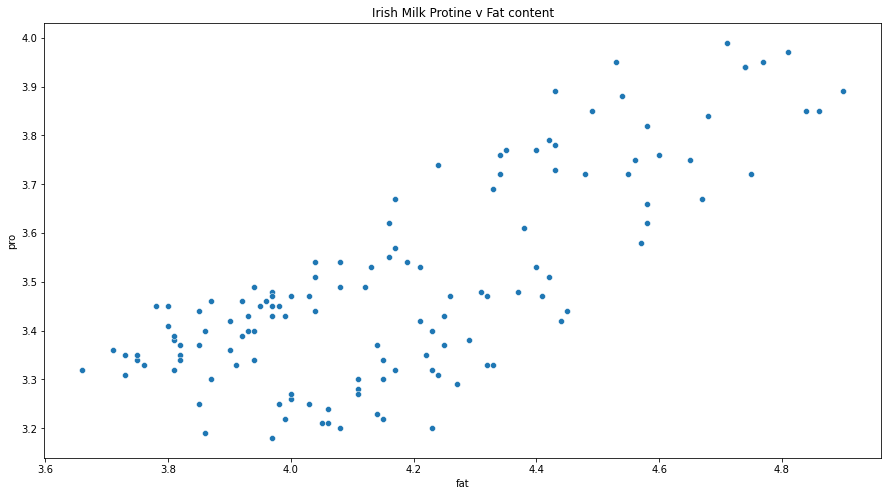

In [578]:
sns.scatterplot(data=ddfd, x= 'fat', y='pro').set(title = 'Irish Milk Protine v Fat content')
plt.savefig("Scatter_IE_fat_pro.png", dpi=300)
plt.show();

# There are no outliers jumping out here 

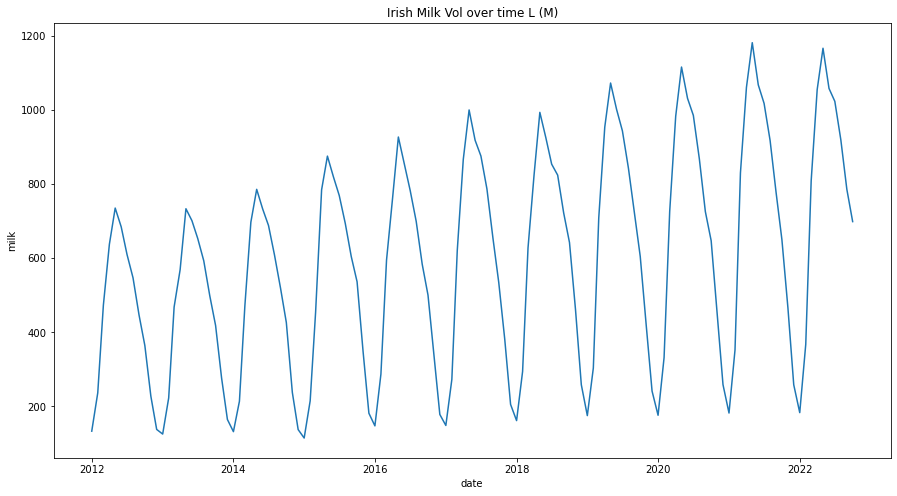

In [546]:
sns.lineplot(data=ddfd, x= 'date', y='milk').set(title = 'Irish Milk Vol over time L (M)')
plt.savefig("Line_IE_Milk_time.png", dpi=300);

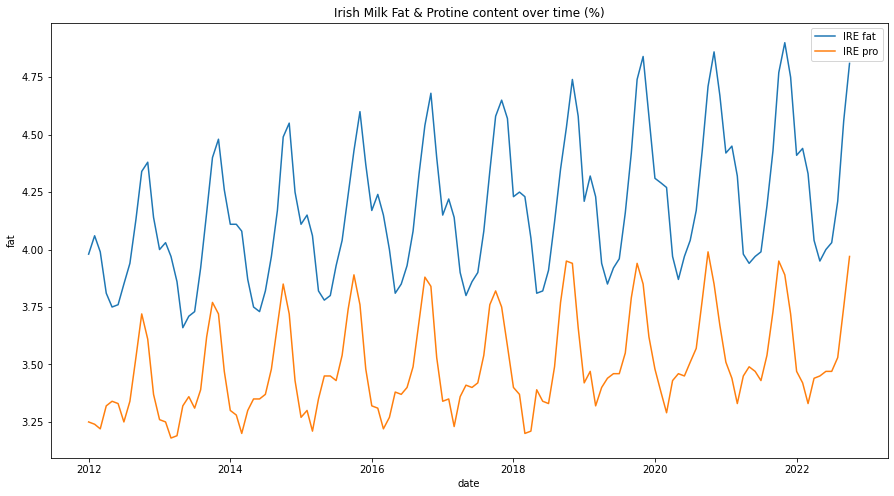

In [579]:
sns.lineplot(data=ddfd, x= 'date', y='fat').set(title = 'Irish Milk Fat & Protine content over time (%)')
sns.lineplot(data=ddfd, x= 'date', y='pro')
plt.legend(labels=["IRE fat","IRE pro"])
plt.savefig("Line_IE_fat_pro_time.png", dpi=300)
plt.show();

In [548]:
# Save out cleaned datyaset for use in other sections od assesment
ddfd.to_csv('IE_Intake of Cows Milk Cleaned.csv')

In [549]:
# import Irish dairy price  as dpdf
dpdf = pd.read_csv("AJM07.20221211151826.csv")

In [550]:
dpdf.tail()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02136V02577,Product,UNIT,VALUE
421,AJM07,Manufacturing Milk Prices (including VAT),202207,2022 July,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.549
422,AJM07,Manufacturing Milk Prices (including VAT),202208,2022 August,1,"Milk (per litre), actual fat and protein",Euro,0.616
423,AJM07,Manufacturing Milk Prices (including VAT),202208,2022 August,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.557
424,AJM07,Manufacturing Milk Prices (including VAT),202209,2022 September,1,"Milk (per litre), actual fat and protein",Euro,0.662
425,AJM07,Manufacturing Milk Prices (including VAT),202209,2022 September,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.559


In [551]:
dpdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATISTIC        426 non-null    object 
 1   STATISTIC Label  426 non-null    object 
 2   TLIST(M1)        426 non-null    int64  
 3   Month            426 non-null    object 
 4   C02136V02577     426 non-null    int64  
 5   Product          426 non-null    object 
 6   UNIT             426 non-null    object 
 7   VALUE            426 non-null    float64
dtypes: float64(1), int64(2), object(5)
memory usage: 26.8+ KB


In [552]:
dpdf[["Month"]] = dpdf[["Month"]].apply(pd.to_datetime)

In [553]:
dpdf.head()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02136V02577,Product,UNIT,VALUE
0,AJM07,Manufacturing Milk Prices (including VAT),200501,2005-01-01,1,"Milk (per litre), actual fat and protein",Euro,0.308
1,AJM07,Manufacturing Milk Prices (including VAT),200501,2005-01-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.301
2,AJM07,Manufacturing Milk Prices (including VAT),200502,2005-02-01,1,"Milk (per litre), actual fat and protein",Euro,0.288
3,AJM07,Manufacturing Milk Prices (including VAT),200502,2005-02-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.281
4,AJM07,Manufacturing Milk Prices (including VAT),200503,2005-03-01,1,"Milk (per litre), actual fat and protein",Euro,0.272


In [554]:
dpdf = dpdf[(dpdf['Month'] >= '2012-01-01')]
dpdf.tail()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02136V02577,Product,UNIT,VALUE
421,AJM07,Manufacturing Milk Prices (including VAT),202207,2022-07-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.549
422,AJM07,Manufacturing Milk Prices (including VAT),202208,2022-08-01,1,"Milk (per litre), actual fat and protein",Euro,0.616
423,AJM07,Manufacturing Milk Prices (including VAT),202208,2022-08-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.557
424,AJM07,Manufacturing Milk Prices (including VAT),202209,2022-09-01,1,"Milk (per litre), actual fat and protein",Euro,0.662
425,AJM07,Manufacturing Milk Prices (including VAT),202209,2022-09-01,2,"Milk (per litre), 3.7% fat and 3.3% protein",Euro,0.559


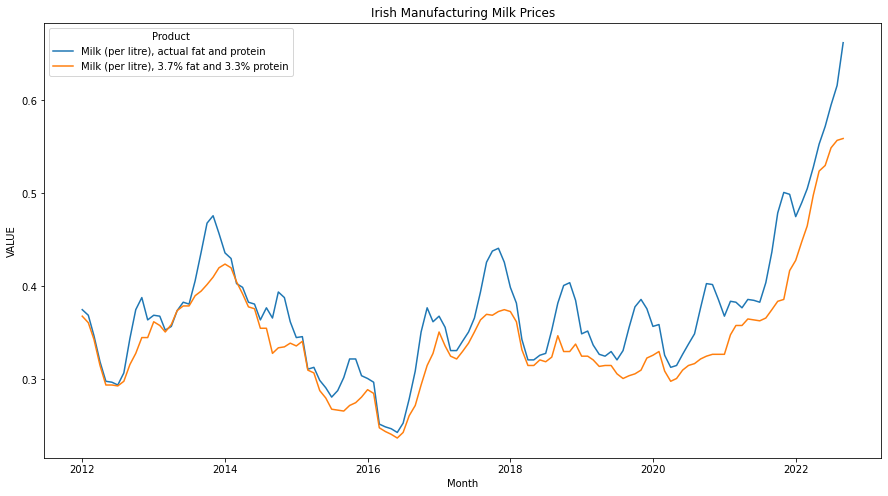

In [555]:
sns.lineplot(data=dpdf, x= 'Month', y='VALUE',hue='Product').set(title = 'Irish Manufacturing Milk Prices')
plt.show()

In [556]:
#!pip install odfpy

In [557]:
# dataset from eurostat
eudf = pd.read_csv("EU_apro_mk_cola_page_linear.csv")

In [558]:
eudf.head()

,DATAFLOW,LAST UPDATE,freq,dairyprod,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2017,57.36,p
1,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2018,64.39,NaN
2,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2019,56.82,NaN
3,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2020,56.27,NaN
4,ESTAT:APRO_MK_COLA$DEFAULTVIEW(1.0),30/11/22 23:00:00,A,D1110D,THS_T,AL,2021,58.94,NaN


In [559]:
# want to drop indicator col from the dataframe
eudf = eudf.drop(['DATAFLOW','LAST UPDATE','freq','dairyprod','unit','OBS_FLAG'], axis=1)

In [560]:
eudf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo          396 non-null    object 
 1   TIME_PERIOD  396 non-null    int64  
 2   OBS_VALUE    373 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 9.4+ KB


In [561]:
#eudf['geo'] = eudf['geo'].astype(str)
# convert date colum to datetime object
#eudf['TIME_PERIOD'] =  pd.to_date(eudf['TIME_PERIOD'])
# format the date column in Year-Date-Month
#eudf[["TIME_PERIOD"]] = eudf[["TIME_PERIOD"]].apply(pd.to_datetime, format = "%Y")
# eudf.info()

In [562]:
eudf.head()

,geo,TIME_PERIOD,OBS_VALUE
0,AL,2017,57.36
1,AL,2018,64.39
2,AL,2019,56.82
3,AL,2020,56.27
4,AL,2021,58.94


In [563]:
uniqueValsList = list(np.unique(np.array(eudf['geo'])))
uniqueValsList

['AL',
 'AT',
 'BA',
 'BE',
 'BG',
 'CH',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'EFTA',
 'EL',
 'ES',
 'EU15',
 'EU25',
 'EU27_2007',
 'EU27_2020',
 'EU28',
 'FI',
 'FR',
 'HR',
 'HU',
 'IE',
 'IS',
 'IT',
 'LT',
 'LU',
 'LV',
 'ME',
 'MK',
 'MT',
 'NL',
 'NO',
 'PL',
 'PT',
 'RO',
 'RS',
 'SE',
 'SI',
 'SK',
 'TR',
 'UK']

In [564]:
# lambda function to filter out strings of 2 charecters long.
eudf=eudf[eudf['geo'].apply(lambda x: len(str(x))<=2)]
#df=df[df.A.apply(lambda x: len(str(x))==10]

In [565]:
#uniqueValsList = list(np.unique(np.array(eudf['geo'])))
#uniqueValsList
item_counts = eudf["geo"].value_counts()
item_counts

HU    10
SI    10
RS    10
RO    10
PT    10
PL    10
NL    10
SK    10
TR    10
LV    10
LU    10
LT    10
IT    10
AT    10
IE    10
SE    10
HR    10
DE    10
BE    10
BG    10
CY    10
FR    10
CZ    10
DK    10
EE    10
EL    10
ES    10
FI    10
MT     9
NO     9
CH     9
BA     9
IS     9
UK     8
ME     8
AL     5
MK     2
Name: geo, dtype: int64

In [566]:
#uniqueValsList = list(np.unique(np.array(eudf['geo'])))
#uniqueValsList
item_counts = eudf["TIME_PERIOD"].value_counts()
item_counts

2019    37
2017    36
2018    36
2013    35
2014    35
2015    35
2020    34
2016    34
2021    33
2012    33
Name: TIME_PERIOD, dtype: int64

In [567]:
eudf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 395
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   geo          348 non-null    object 
 1   TIME_PERIOD  348 non-null    int64  
 2   OBS_VALUE    341 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ KB


In [568]:
# recheck my data frame for NaNs one column has 7
# plus 2 in the foot _fall count
eudf.isna().sum()

geo            0
TIME_PERIOD    0
OBS_VALUE      7
dtype: int64

In [569]:
# for a closer inspection select the rows with null 
eudf[eudf.isna().any(axis=1)]

,geo,TIME_PERIOD,OBS_VALUE
221,IS,2012,NaN
222,IS,2013,NaN
257,LU,2019,NaN
258,LU,2020,NaN
259,LU,2021,NaN
280,MT,2012,NaN
281,MT,2013,NaN


In [570]:
eudf['OBS_VALUE'] = eudf['OBS_VALUE'].fillna(0)

In [571]:
cc = pd.read_csv('country_codes.tsv',sep='\t')
cc.head()

,Country,Alpha-2 code,Alpha-3 code,Numeric
0,Afghanistan,AF,AFG,4
1,Albania,AL,ALB,8
2,Algeria,DZ,DZA,12
3,American Samoa,AS,ASM,16
4,Andorra,AD,AND,20


In [572]:
# made a mapping dictionary from the country code dataframe
# and mapped in the Alpha-3 country codes, because this is what the plotting step needs
# to work with.
mapping = dict(cc[['Alpha-2 code', 'Alpha-3 code']].values)
eudf['code'] = eudf.geo.map(mapping)


In [573]:
# I repeated the mapping , but this time to add the country name to the dataframe.
# With this I made  the hover feature show country name , else I was stuck with country code.
mapping = dict(cc[['Alpha-2 code', 'Country']].values)
eudf['country'] = eudf.geo.map(mapping)
eudf.head()

,geo,TIME_PERIOD,OBS_VALUE,code,country
0,AL,2017,57.36,ALB,Albania
1,AL,2018,64.39,ALB,Albania
2,AL,2019,56.82,ALB,Albania
3,AL,2020,56.27,ALB,Albania
4,AL,2021,58.94,ALB,Albania


In [574]:
# eudf.sort_values(by='TIME_PERIOD')
#eudf['TIME_PERIOD'] = pd.to_datetime(eudf['TIME_PERIOD'])
#eudf = eudf.sort_values('TIME_PERIOD', ascending=True)
#eudf['TIME_PERIOD'] = eudf['TIME_PERIOD'].dt.strftime('%m-%d-%Y')
#eudf.head()
#eudf['TIME_PERIOD'] = pd.to_datetime(eudf['TIME_PERIOD'], errors='coerce').astype(str)
#eudf['TIME_PERIOD'] = pd.to_datetime(eudf['TIME_PERIOD']).dt.year

In [575]:
import plotly.express as px
fig = px.choropleth(eudf.sort_values('TIME_PERIOD'), locations="code",
                    color="OBS_VALUE", 
                    hover_name="country", 
                    # column to add to hover information
                    animation_frame="TIME_PERIOD", 
                    # column on which to animate
                    color_continuous_scale=px.colors.sequential.Plasma)
                    
fig.update_layout(
    # add a title text for the plot
    title_text = 'Milk Production',
    # set projection style for the plot
    geo = dict(projection={'type':'natural earth'}) # by default, projection type is set to 'equirectangular'
)
fig.show()

In [576]:
fig = px.choropleth(eudf.sort_values('TIME_PERIOD'),locations="code",color="OBS_VALUE",
                    hover_name="country",animation_frame="TIME_PERIOD",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(
    title_text="EU Milk Production",
    geo_scope="europe"# change this to 'aisa' or 'europe' or 'africa' to zoop

)
fig.show()

# EDA on Dutch Milk production
## With emphisis on fat and protine content of milk 
## by month

In [457]:
# First attempt to import the dairy csv as ddf
# headers are axcross two lines , combine these with headers = [0,1]
nl_ddf = pd.read_csv("NL_Milk_supply_and_dairy_production_by_dairy_factories_19122022_110338.csv",header=[0,1],doublequote=True,delimiter=';',skiprows=3,on_bad_lines='skip')

In [458]:
nl_ddf.head()

,Unnamed: 0_level_0,Milk supply|Volume,Milk supply|Fat content,Milk supply|Protein content,Dairy production|Butter,Dairy production|Cheese,Dairy production|Milk powder|Total Milk powder,Dairy production|Milk powder|Whole milk powder,Dairy production|Milk powder|Skimmed-milk powder,Dairy production|Concentrated milk,Dairy production|Whey powder
,Periods,1 000 kg,%,%,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg
0,1995 January,911676,4.58,3.54,14380.0,58071.0,13205.0,9250.0,3955.0,29397.0,.
1,1995 February,837617,4.52,3.48,12263.0,53419.0,10960.0,8349.0,2611.0,28294.0,.
2,1995 March,940083,4.51,3.46,12699.0,59799.0,13828.0,11085.0,2743.0,31102.0,.
3,1995 April,935337,4.50,3.44,12702.0,57396.0,14758.0,12194.0,2564.0,30827.0,.
4,1995 May,985108,4.34,3.45,11979.0,59326.0,17883.0,13531.0,4352.0,31917.0,.


In [459]:
nl_ddf.info()
# the resulto of the .info are telling me there is a null in each column with respect to the period column.
# I need to investigate this further.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346 entries, 0 to 345
Data columns (total 11 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   (Unnamed: 0_level_0, Periods)                                 346 non-null    object 
 1   (Milk supply|Volume, 1 000 kg)                                345 non-null    object 
 2   (Milk supply|Fat content, %)                                  345 non-null    float64
 3   (Milk supply|Protein content, %)                              345 non-null    float64
 4   (Dairy production|Butter, 1 000 kg)                           345 non-null    float64
 5   (Dairy production|Cheese, 1 000 kg)                           345 non-null    float64
 6   (Dairy production|Milk powder|Total Milk powder, 1 000 kg)    345 non-null    float64
 7   (Dairy production|Milk powder|Whole milk powder, 1 000 kg)    345 non-n

In [460]:
# This line pulls out all rows where the column has a null value, I did this to further investigate my null values.
nl_ddf[nl_ddf.isna().any(axis=1)]
# the result shows this to be a comment line referencing where this data came from. RVO is the 
# dutch government stats portal

,Unnamed: 0_level_0,Milk supply|Volume,Milk supply|Fat content,Milk supply|Protein content,Dairy production|Butter,Dairy production|Cheese,Dairy production|Milk powder|Total Milk powder,Dairy production|Milk powder|Whole milk powder,Dairy production|Milk powder|Skimmed-milk powder,Dairy production|Concentrated milk,Dairy production|Whey powder
,Periods,1 000 kg,%,%,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg
345,Source: RVO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [461]:
# This line will be a problem so it has to go
# delete rows with null
nl_ddf.dropna() 

,Unnamed: 0_level_0,Milk supply|Volume,Milk supply|Fat content,Milk supply|Protein content,Dairy production|Butter,Dairy production|Cheese,Dairy production|Milk powder|Total Milk powder,Dairy production|Milk powder|Whole milk powder,Dairy production|Milk powder|Skimmed-milk powder,Dairy production|Concentrated milk,Dairy production|Whey powder
,Periods,1 000 kg,%,%,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg
0,1995 January,911676,4.58,3.54,14380.0,58071.0,13205.0,9250.0,3955.0,29397.0,.
1,1995 February,837617,4.52,3.48,12263.0,53419.0,10960.0,8349.0,2611.0,28294.0,.
2,1995 March,940083,4.51,3.46,12699.0,59799.0,13828.0,11085.0,2743.0,31102.0,.
3,1995 April,935337,4.50,3.44,12702.0,57396.0,14758.0,12194.0,2564.0,30827.0,.
4,1995 May,985108,4.34,3.45,11979.0,59326.0,17883.0,13531.0,4352.0,31917.0,.
...,...,...,...,...,...,...,...,...,...,...,...
340,2022 June*,"1148,199",4.25,3.48,11632.0,79422.0,19407.0,8906.0,10501.0,31354.0,.
341,2022 July*,"1164,104",4.20,3.45,12302.0,79107.0,18633.0,8328.0,10305.0,31446.0,.
342,2022 August*,"1147,712",4.21,3.46,11951.0,77360.0,16044.0,6365.0,9679.0,31548.0,.


In [462]:
# This line sums the number of NaN in the dataframe by column
nl_ddf.isna().sum()

Unnamed: 0_level_0                                Periods     0
Milk supply|Volume                                1 000 kg    1
Milk supply|Fat content                           %           1
Milk supply|Protein content                       %           1
Dairy production|Butter                           1 000 kg    1
Dairy production|Cheese                           1 000 kg    1
Dairy production|Milk powder|Total Milk powder    1 000 kg    1
Dairy production|Milk powder|Whole milk powder    1 000 kg    1
Dairy production|Milk powder|Skimmed-milk powder  1 000 kg    1
Dairy production|Concentrated milk                1 000 kg    1
Dairy production|Whey powder                      1 000 kg    1
dtype: int64

In [463]:
# shorten long heddings to abbreviations to make the data frame more readable.
# Make a dict to convert heddings.
head_dict = {"(Unnamed: 0_level_0, Periods)":"date",
             "(Milk supply|Volume, 1 000 kg)":"milk,1000kg",
             "(Milk supply|Fat content, %)":"fat,%",
             "(Milk supply|Protein content, %)":"protein,%"
            }

In [464]:
# call the rename method
nl_ddf.rename(columns = head_dict, inplace=True)

In [465]:
nl_ddf.head()

,Unnamed: 0_level_0,Milk supply|Volume,Milk supply|Fat content,Milk supply|Protein content,Dairy production|Butter,Dairy production|Cheese,Dairy production|Milk powder|Total Milk powder,Dairy production|Milk powder|Whole milk powder,Dairy production|Milk powder|Skimmed-milk powder,Dairy production|Concentrated milk,Dairy production|Whey powder
,Periods,1 000 kg,%,%,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg,1 000 kg
0,1995 January,911676,4.58,3.54,14380.0,58071.0,13205.0,9250.0,3955.0,29397.0,.
1,1995 February,837617,4.52,3.48,12263.0,53419.0,10960.0,8349.0,2611.0,28294.0,.
2,1995 March,940083,4.51,3.46,12699.0,59799.0,13828.0,11085.0,2743.0,31102.0,.
3,1995 April,935337,4.50,3.44,12702.0,57396.0,14758.0,12194.0,2564.0,30827.0,.
4,1995 May,985108,4.34,3.45,11979.0,59326.0,17883.0,13531.0,4352.0,31917.0,.


In [466]:
# Import the dairy csv as ddf
nl_ddf2 = pd.read_csv("NL_Milk_supply_and_dairy_production_by_dairy_factories_19122022_110338.csv",header=None,doublequote=True,delimiter=';',skiprows=5,on_bad_lines='skip')
nl_ddf2.columns = ["date", "milk", "fat", "pro","butter","cheese","powder tot","powder who","powder skim","con","whey"]
nl_ddf2.head()

,date,milk,fat,pro,butter,cheese,powder tot,powder who,powder skim,con,whey
0,1995 January,911676,4.58,3.54,14380.0,58071.0,13205.0,9250.0,3955.0,29397.0,.
1,1995 February,837617,4.52,3.48,12263.0,53419.0,10960.0,8349.0,2611.0,28294.0,.
2,1995 March,940083,4.51,3.46,12699.0,59799.0,13828.0,11085.0,2743.0,31102.0,.
3,1995 April,935337,4.50,3.44,12702.0,57396.0,14758.0,12194.0,2564.0,30827.0,.
4,1995 May,985108,4.34,3.45,11979.0,59326.0,17883.0,13531.0,4352.0,31917.0,.


In [467]:
# Use a lambda function to split the year and month out in order to clean up the dates data
nl_ddf2[['year','month']] = nl_ddf2.date.apply(lambda x: pd.Series(str(x).split(" ")))

In [468]:
# cleaning step , make sure the month txt is a string because it will need to be in a string format for convert to dsate later
nl_ddf2['month'].astype(str)
# strip out any white spaces that might be at the beginning or ends of strings as these cause problems for other functions
nl_ddf2['month']=nl_ddf2['month'].str.strip()

In [469]:
# looking at what what I got , all months have a duplicate with a *. the hover data from the duthc site indicated this 
# to me prelimenary data , which is incorporated in the final data , so need to eliminate this.
# also showing is Feburary with just 24 entries but with two additional feb columns spelled wrong.
# correcting the spelling on these columns would bring them up to 26 same as the other columns.
# there is one column with no name.
item_counts = nl_ddf2["month"].value_counts()
item_counts

January       26
July          26
December      26
November      26
October       26
August        26
September     26
June          26
May           26
April         26
March         26
February      24
April*         2
August*        2
July*          2
June*          2
May*           2
September*     2
March*         2
February*      2
January*       2
October*       2
November*      1
December*      1
               1
Februay        1
Feburary       1
RVO            1
Name: month, dtype: int64

In [470]:
# use regex to converting the white spaces to np.nan, else they show up as being valid charecters
nl_ddf2 = nl_ddf2.replace(r'^\s*$',np.nan, regex=True)

In [471]:
nl_ddf2.isna().sum()

date            0
milk            1
fat             1
pro             1
butter          1
cheese          1
powder tot      1
powder who      1
powder skim     1
con             1
whey            1
year            0
month          11
dtype: int64

In [472]:
# for a closer inspection select the rows with null 
ps = nl_ddf2[nl_ddf2.isna().any(axis=1)]

In [473]:
# On inspecting one of the problem rows with loc I coud see the issue was 
# some years had a total colums at the end of the data.
# Here I was trying to inspect all the problem years in one go with a loop.
# the loop was supposed to display the 12 months before the problem row.
# by saving one year chunks of data into a list of dataframes. but it did not work.
# loc wont display in a loop , and 
#from IPython.display import display # this is a library that displays dataframes in a list tiadly.
#df_list=[]  # empyt list
#print(ps.index)
#for idx in ps.index: # looping over the index 
    #df_list.append[nl_ddf2.loc[idx-10:idx]]
#display(df_list)
    


#def show_problem_year(df):
#    temp_frames = []
#    for idx in df.index:
#        start_year = idx - 10
#        temp_frame = df.loc[start_year:idx]
#        temp_frames.append[temp_frame]
#   display(temp_frames)


        
        
#problem_frames = show_problem_year(ps)

In [474]:
ps.index

Int64Index([12, 73, 134, 195, 256, 269, 282, 295, 308, 321, 334, 345], dtype='int64')

In [475]:
# I stepped through the index indivigually to select a 12 month slice of the data.
# every problem row listed in ps looks to be a total row for the previous year , except for the 
# last one which is a 
# reference to the data source. I also notice 2022 and 2022 data is marked as prelimenary.
# I will go ahead with this data as a sourcs and verify it against another data sources later 
# Im also noticing commas in some data and not others , need to clean up the commas and make this a int column.

# by just entering the index values , this codes pulls a 12 month slice of the data for inspection
# while tedious , its effective and got me past the sticking point I describe above while trying to automate this.

a = 345
b = (a - 12)
nl_ddf2.loc[b:a]


,date,milk,fat,pro,butter,cheese,powder tot,powder who,powder skim,con,whey,year,month
333,2021 December*,"1121,498",4.56,3.59,11967.0,78314.0,15751.0,7582.0,8169.0,31290.0,.,2021,December*
334,2021*,"13603,304",4.45,3.59,137503.0,946760.0,209138.0,118152.0,90986.0,391644.0,.,2021*,NaN
335,2022 January*,"1157,925",4.53,3.57,11895.0,78898.0,16204.0,7489.0,8715.0,32113.0,.,2022,January*
336,2022 February*,"1067,665",4.51,3.57,11825.0,73682.0,15195.0,7153.0,8042.0,31587.0,.,2022,February*
337,2022 March*,"1187,383",4.52,3.57,11911.0,79354.0,17082.0,7943.0,9139.0,32598.0,.,2022,March*
338,2022 April*,"1154,138",4.47,3.54,12456.0,79752.0,17388.0,8149.0,9239.0,31945.0,.,2022,April*
339,2022 May*,"1206,816",4.34,3.52,14109.0,81443.0,19391.0,9568.0,9823.0,32212.0,.,2022,May*
340,2022 June*,"1148,199",4.25,3.48,11632.0,79422.0,19407.0,8906.0,10501.0,31354.0,.,2022,June*
341,2022 July*,"1164,104",4.20,3.45,12302.0,79107.0,18633.0,8328.0,10305.0,31446.0,.,2022,July*
342,2022 August*,"1147,712",4.21,3.46,11951.0,77360.0,16044.0,6365.0,9679.0,31548.0,.,2022,August*


In [476]:
# Im now confident I can delete the rows where month is NAN as these are total rows.
# delete rows with null in the month column
nl_ddf2.dropna(subset=['month'], inplace=True)
nl_ddf2 = nl_ddf2.drop(345) # this row is the reference to the data source


In [477]:
# strips out the * at the end of some month strings.I do this bercause the * is preventing me from making 
# a datetimne object from the date info
# error , strips the last char for all words, lambda <args> : <statement1> if <condition > ( <statement2> if <condition> else <statement3>)
#nl_ddf2['month'] = (lambda x : x if x[-1] != '*' else nl_ddf2['month'].str[:-1])
nl_ddf2 = nl_ddf2.replace(r'^\s*$',np.nan, regex=True)


nl_ddf2['month'] = nl_ddf2['month'].map(lambda x: x.rstrip('*'))

In [478]:
# Sanity check dataframe is processed ok, month column no nonger has *
nl_ddf2.loc[b:a]

,date,milk,fat,pro,butter,cheese,powder tot,powder who,powder skim,con,whey,year,month
333,2021 December*,"1121,498",4.56,3.59,11967.0,78314.0,15751.0,7582.0,8169.0,31290.0,.,2021,December
335,2022 January*,"1157,925",4.53,3.57,11895.0,78898.0,16204.0,7489.0,8715.0,32113.0,.,2022,January
336,2022 February*,"1067,665",4.51,3.57,11825.0,73682.0,15195.0,7153.0,8042.0,31587.0,.,2022,February
337,2022 March*,"1187,383",4.52,3.57,11911.0,79354.0,17082.0,7943.0,9139.0,32598.0,.,2022,March
338,2022 April*,"1154,138",4.47,3.54,12456.0,79752.0,17388.0,8149.0,9239.0,31945.0,.,2022,April
339,2022 May*,"1206,816",4.34,3.52,14109.0,81443.0,19391.0,9568.0,9823.0,32212.0,.,2022,May
340,2022 June*,"1148,199",4.25,3.48,11632.0,79422.0,19407.0,8906.0,10501.0,31354.0,.,2022,June
341,2022 July*,"1164,104",4.20,3.45,12302.0,79107.0,18633.0,8328.0,10305.0,31446.0,.,2022,July
342,2022 August*,"1147,712",4.21,3.46,11951.0,77360.0,16044.0,6365.0,9679.0,31548.0,.,2022,August
343,2022 September*,"1105,982",4.36,3.53,11705.0,76128.0,14847.0,6043.0,8804.0,31371.0,.,2022,September


In [479]:
# there are a number of provisional figures in this dataframer identified by a * in the need to delete these.
# I need to remove these as thet are not part of my overall data.

#nl_ddf2=nl_ddf2[nl_ddf2['month'].apply(lambda x: x[-1] != '*')] #  email sam why this doesnt work.
#l_ddf2 = nl_ddf2[nl_ddf2['month'].apply(lambda x : x in allowed_chars)]
# nl_ddf2 = nl_ddf2[nl_ddf2['month'].apply(lambda x : x in allowed_chars)]

# lambda x: x if x.endswith('@')
#nl_ddf2.drop(nl_ddf2[nl_ddf2['month'][-1] == "*"].index, inplace = True)

#nl_ddf2=nl_ddf2[nl_ddf2['month'][-1] != '*']

# Im now keeping this data , su just need to delete the * now.
#nl_ddf2 = nl_ddf2.replace(r'^\w*$',np.nan, regex=True)

In [480]:
# recheck my values , to review what anomolies are still outstanding. 
item_counts = nl_ddf2["month"].value_counts()
item_counts

January      28
March        28
April        28
May          28
June         28
July         28
August       28
September    28
October      28
November     27
December     27
February     26
Feburary      1
Februay       1
Name: month, dtype: int64

In [481]:
# calling the custom function astype_change and passing in the dataframe and dictionary
# milk was astype object with commas, convert to string first to manipulate at next stage
nl_ddf2['milk'] = nl_ddf2['milk'].astype(str)
nl_ddf2['month'] = nl_ddf2['month'].astype(str)
# Im converting all dates to lower because the spell check below returns lower case strings.
nl_ddf2['month'] = nl_ddf2['month'].apply(lambda x : x.lower())
# now able to replace unwanted "," in the number column with '' 
nl_ddf2['milk'] = nl_ddf2['milk'].apply(lambda x : x.replace(',',''))
# with milk column cleaned can now convert back to an int
nl_ddf2['milk'] = nl_ddf2['milk'].astype(int)
# there werre spelling errors in the date fields causing problems in converting to datetime,
# used custom correct function to spell check this field.
nl_ddf2['month'] = nl_ddf2['month'].apply(lambda x : correct(x))
# rejoin the year and month column
nl_ddf2['date'] = nl_ddf2['year'] + " " + nl_ddf2['month']# there werre spelling errors in the date fields causing problems in converting to datetime,

# used a convert dict to cahange the astype of the milk colums to float for further manipulation.
convert_dict = {'milk': float}
nl_ddf2['milk'] = nl_ddf2['milk'].astype(convert_dict)
# finally with the date filed spellings corrected above , now able to make this a date time object column.
nl_ddf2[["date"]] = nl_ddf2[["date"]].apply(pd.to_datetime)

# nl_ddf2 = astype_change(nl_ddf2['milk'],convert_dict)

In [482]:
item_counts = nl_ddf2["month"].value_counts()
item_counts

january      28
february     28
march        28
april        28
may          28
june         28
july         28
august       28
september    28
october      28
november     27
december     27
Name: month, dtype: int64

In [483]:
nl_ddf2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334 entries, 0 to 344
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         334 non-null    datetime64[ns]
 1   milk         334 non-null    float64       
 2   fat          334 non-null    float64       
 3   pro          334 non-null    float64       
 4   butter       334 non-null    float64       
 5   cheese       334 non-null    float64       
 6   powder tot   334 non-null    float64       
 7   powder who   334 non-null    float64       
 8   powder skim  334 non-null    float64       
 9   con          334 non-null    float64       
 10  whey         334 non-null    object        
 11  year         334 non-null    object        
 12  month        334 non-null    object        
dtypes: datetime64[ns](1), float64(9), object(3)
memory usage: 44.6+ KB


In [484]:
nl_ddf2 = nl_ddf2[(nl_ddf2['date'] >= '2012-01-01')]
nl_ddf2.tail()

,date,milk,fat,pro,butter,cheese,powder tot,powder who,powder skim,con,whey,year,month
340,2022-06-01,1148199.0,4.25,3.48,11632.0,79422.0,19407.0,8906.0,10501.0,31354.0,.,2022,june
341,2022-07-01,1164104.0,4.20,3.45,12302.0,79107.0,18633.0,8328.0,10305.0,31446.0,.,2022,july
342,2022-08-01,1147712.0,4.21,3.46,11951.0,77360.0,16044.0,6365.0,9679.0,31548.0,.,2022,august
343,2022-09-01,1105982.0,4.36,3.53,11705.0,76128.0,14847.0,6043.0,8804.0,31371.0,.,2022,september
344,2022-10-01,1139853.0,4.49,3.63,12947.0,60315.0,16640.0,6263.0,10377.0,31192.0,.,2022,october


[Text(0.5, 1.0, 'Dutch Milk Vol over time')]

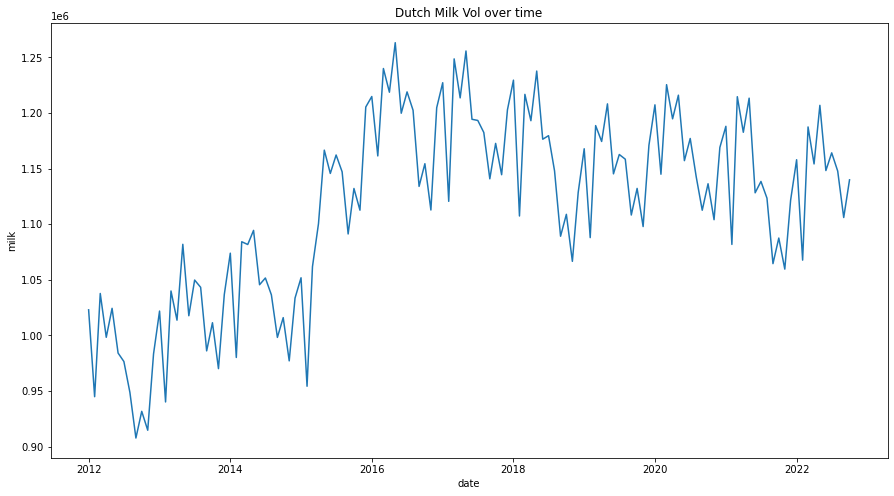

In [485]:
sns.lineplot(data=nl_ddf2, x= 'date', y='milk').set(title = 'Dutch Milk Vol over time')
# milk quots removed after 2014 , result shows a big jump in production but wirth declining volumes there after.

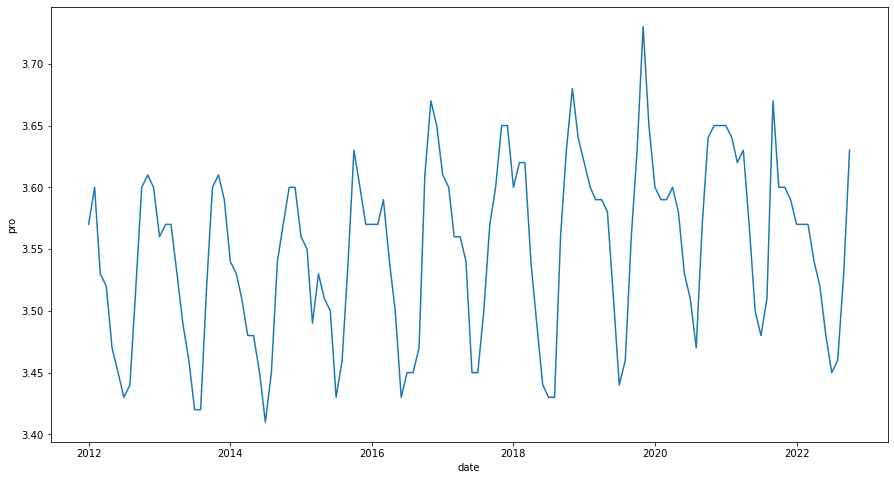

In [486]:
## ax=sns.lineplot(data=nl_ddf2, x= 'date', y='fat').set(title = 'Dutch Milk Fat & Protine content over time')
ax=sns.lineplot(data=nl_ddf2, x= 'date', y='pro')

plt.show()

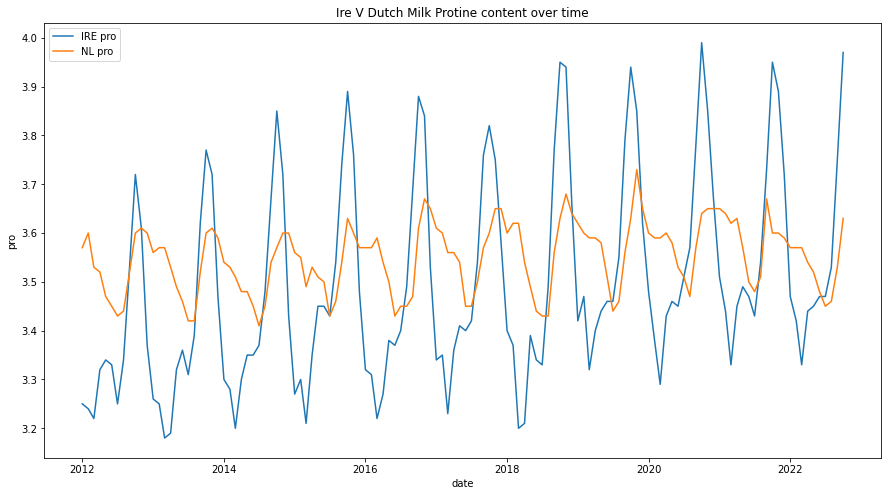

In [487]:
# High Protine content leads to higher prices and is the aim of farming.
sns.lineplot(data=ddfd, x= 'date', y='pro').set(title = 'Ire V Dutch Milk Protine content over time')
sns.lineplot(data=nl_ddf2, x= 'date', y='pro')
plt.legend(labels=["IRE pro","NL pro"])
plt.show()

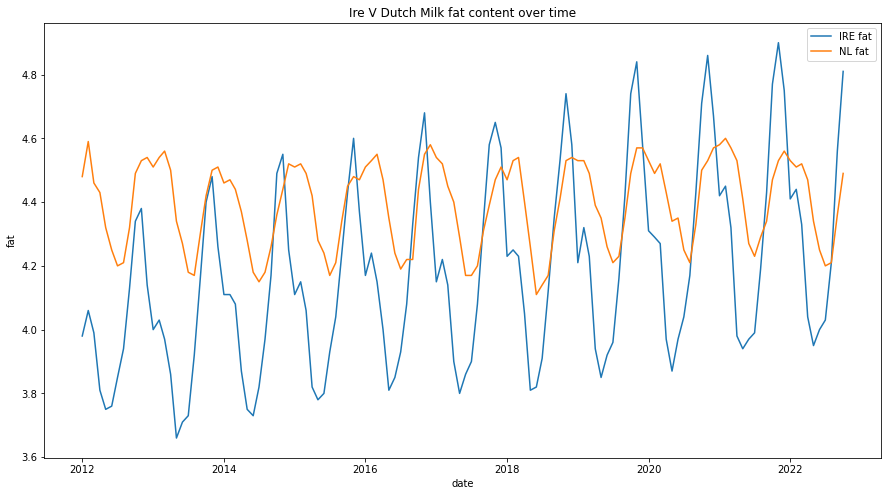

In [488]:
# High fat content leads to higher prices and is the aim of farming.
sns.lineplot(data=ddfd, x= 'date', y='fat').set(title = 'Ire V Dutch Milk fat content over time')
sns.lineplot(data=nl_ddf2, x= 'date', y='fat')
plt.legend(labels=["IRE fat","NL fat"])
plt.show()

In [489]:
# Save out cleaned datyaset for use in other sections od assesment
nl_ddf2.to_csv('NL_Milk_supply_and_dairy_production_Cleaned.csv')

# Weather data
## From Cork and Dublin will be used to
## Data is in daily form and will be averaged for the month in question.

In [490]:
# Dublin * Cork Weather data set loaded
cw = pd.read_csv("dly3904.csv",skiprows=24,on_bad_lines='skip')

In [491]:
cw.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,...,ind.5,hg,sun,dos,soil,pe,evap,smd_wd,smd_md,smd_pd
0,01-jan-1962,0,2.8,1,-2.5,,,8,,999.6,...,0,24,,0,,,,,,
1,02-jan-1962,0,2.8,1,-3.7,,,8,,1005.8,...,0,10,,0,,,,,,
2,03-jan-1962,0,2.3,1,-3.8,,,8,,1007.8,...,0,13,,0,,,,,,
3,04-jan-1962,0,6.6,0,0.6,,,8,,1007.8,...,0,12,,0,,,,,,
4,05-jan-1962,0,9.3,0,0.6,,,8,,1002.2,...,0,29,,0,,,,,,


In [492]:
# convert date colum to datetime object

cw['date'] =  pd.to_datetime(cw['date'])
# format the date column in Year-Date-Month

cw[["date"]] = cw[["date"]].apply(pd.to_datetime, format = "%Y/%d/%m")

In [493]:
# select only dates from 2012 on
cw15to20 =  cw[(cw['date'] >= '2012-01-01') & (cw['date'] <= '2020-12-31')]
#cw = cw[(cw['date'] >= '2012-01-01')]

In [494]:
cwmdf.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,...,hg,sun,dos,soil,pe,evap,smd_wd,smd_md,smd_pd,month
19358,2015-01-01,0,12.9,0,7.9,0,7.8,0,15.1,998.4,...,41,0.0,0,9.100,0.4,0.6,0.0,-10.0,-10.0,January
19359,2015-01-02,0,8.0,0,1.4,1,-1.3,0,2.0,1008.4,...,30,4.6,0,6.050,0.3,0.4,0.0,-1.7,-10.0,January
19360,2015-01-03,0,11.6,0,5.2,1,-1.4,0,9.8,1002.8,...,23,1.2,0,6.750,0.3,0.4,0.0,-9.5,-10.0,January
19361,2015-01-04,0,8.7,0,5.5,0,5.0,0,1.3,1010.1,...,15,0.1,0,7.100,0.3,0.4,0.0,-1.0,-10.0,January
19362,2015-01-05,0,10.1,0,8.2,0,5.7,0,5.3,1000.6,...,26,0.0,0,8.475,0.2,0.4,0.0,-5.1,-10.0,January
19389,2015-02-01,0,5.1,1,-0.2,1,-2.7,3,0.0,991.2,...,22,7.3,0,2.250,0.6,0.9,1.0,1.0,-8.1,February
19390,2015-02-02,0,3.8,0,0.3,1,-4.7,0,0.2,989.7,...,9,0.2,0,2.575,0.5,0.6,1.2,1.2,-7.4,February
19391,2015-02-03,0,4.0,1,-0.1,1,-3.0,0,0.8,995.2,...,20,6.9,0,2.750,0.3,0.5,0.8,0.8,-7.5,February
19392,2015-02-04,0,3.6,1,-2.4,1,-4.7,3,0.0,1006.7,...,20,8.4,0,2.000,0.5,0.7,1.2,1.2,-6.7,February
19393,2015-02-05,0,7.4,1,-0.7,1,-3.7,3,0.0,1011.8,...,20,3.5,0,2.625,0.6,0.8,1.8,1.8,-5.7,February


In [495]:
cw15to20['month'] = cw15to20['date'].apply(lambda x: x.strftime('%B'))

In [496]:
cw15to20.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3288 entries, 18262 to 21549
Data columns (total 26 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3288 non-null   datetime64[ns]
 1   ind     3288 non-null   int64         
 2   maxtp   3288 non-null   float64       
 3   ind.1   3288 non-null   int64         
 4   mintp   3288 non-null   float64       
 5   igmin   3288 non-null   object        
 6   gmin    3288 non-null   object        
 7   ind.2   3288 non-null   int64         
 8   rain    3288 non-null   object        
 9   cbl     3288 non-null   float64       
 10  wdsp    3288 non-null   float64       
 11  ind.3   3288 non-null   int64         
 12  hm      3288 non-null   object        
 13  ind.4   3288 non-null   int64         
 14  ddhm    3288 non-null   int64         
 15  ind.5   3288 non-null   int64         
 16  hg      3288 non-null   int64         
 17  sun     3288 non-null   object        
 18  dos

In [497]:
cw15to20['rain'] = cw15to20['rain'].astype(float)
cw15to20['soil'] = cw15to20['soil'].astype(float)

In [498]:
cwm = cw15to20.groupby(pd.PeriodIndex(cw15to20['date'], freq="M"))['rain','mintp','maxtp','soil'].mean()

In [499]:
cwm = cwm.to_timestamp()

In [500]:
cwm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2012-01-01 to 2020-12-01
Freq: MS
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rain    108 non-null    float64
 1   mintp   108 non-null    float64
 2   maxtp   108 non-null    float64
 3   soil    108 non-null    float64
dtypes: float64(4)
memory usage: 4.2 KB


In [501]:
cwm.isna().sum() 

rain     0
mintp    0
maxtp    0
soil     0
dtype: int64

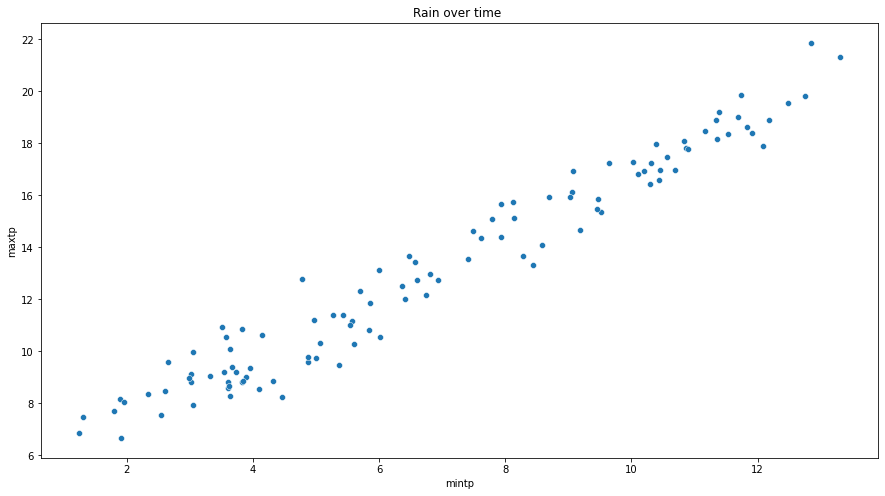

In [580]:
sns.scatterplot(data=cwm, x= 'mintp', y='maxtp').set(title = 'Rain over time ')
plt.savefig("Scatter_IE_Weather.png", dpi=300)
plt.show()

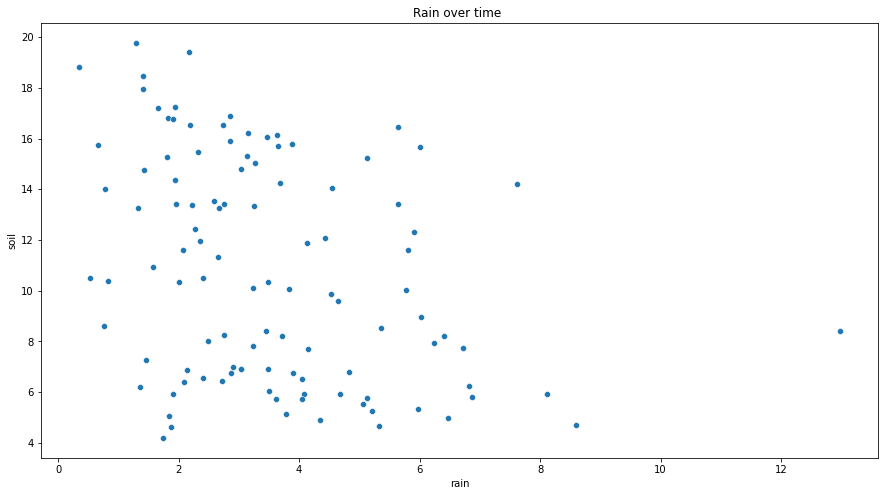

In [503]:
sns.scatterplot(data=cwm, x= 'rain', y='soil').set(title = 'Rain over time ')
plt.show()

In [508]:
# need to set the date to the index for join on
ddfd = ddfd.set_index('date')
#ddfd_1 = 

In [509]:
ddfd.head()

,milk,fat,pro,year,month
date,,,,,
2012-01-01,133.3,3.98,3.25,2012,January
2012-02-01,236.6,4.06,3.24,2012,February
2012-03-01,473.0,3.99,3.22,2012,March
2012-04-01,637.3,3.81,3.32,2012,April
2012-05-01,735.0,3.75,3.34,2012,May


In [510]:
cwm.head()

,rain,mintp,maxtp,soil
date,,,,
2012-01-01,3.035484,4.877419,9.600000,6.917742
2012-02-01,1.462069,5.368966,9.468966,7.259483
2012-03-01,0.764516,5.277419,11.412903,8.621774
2012-04-01,2.753333,3.570000,10.550000,8.260833
2012-05-01,2.351613,7.406452,13.538710,11.976613


In [511]:
# joining the weather and milk dataframes into one 
iedw = cwm.join(ddfd, how='left',on='date')


In [512]:
# save the new dataframe out for use in other notebooks
iedw.to_csv('cork_weather_and_milk.csv')

In [513]:
iedw.tail()

,rain,mintp,maxtp,soil,milk,fat,pro,year,month
date,,,,,,,,,
2020-08-01,5.645161,12.187097,18.887097,16.441935,867.6,4.17,3.57,2020,August
2020-09-01,1.940000,10.106667,16.826667,14.380833,725.4,4.43,3.78,2020,September
2020-10-01,3.825806,6.596774,12.745161,10.071774,646.8,4.71,3.99,2020,October
2020-11-01,5.360000,5.846667,10.820000,8.522500,449.8,4.86,3.85,2020,November
2020-12-01,5.980645,3.045161,7.929032,5.325806,258.8,4.67,3.67,2020,December


In [514]:
# Made dummy variables from month categorical data
# first drop year as I dont want dummy variablrs from this data
iedw = iedw.drop(['year'], axis=1)

In [515]:
iedwd = pd.get_dummies(iedw)
iedwd.head()

,rain,mintp,maxtp,soil,milk,fat,pro,month_April,month_August,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
date,,,,,,,,,,,,,,,,,,,
2012-01-01,3.035484,4.877419,9.600000,6.917742,133.3,3.98,3.25,0,0,0,0,1,0,0,0,0,0,0,0
2012-02-01,1.462069,5.368966,9.468966,7.259483,236.6,4.06,3.24,0,0,0,1,0,0,0,0,0,0,0,0
2012-03-01,0.764516,5.277419,11.412903,8.621774,473.0,3.99,3.22,0,0,0,0,0,0,0,1,0,0,0,0
2012-04-01,2.753333,3.570000,10.550000,8.260833,637.3,3.81,3.32,1,0,0,0,0,0,0,0,0,0,0,0
2012-05-01,2.351613,7.406452,13.538710,11.976613,735.0,3.75,3.34,0,0,0,0,0,0,0,0,1,0,0,0


In [516]:
# using rcParams to make the following graphs bigger as thay contain a lot of detail
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8

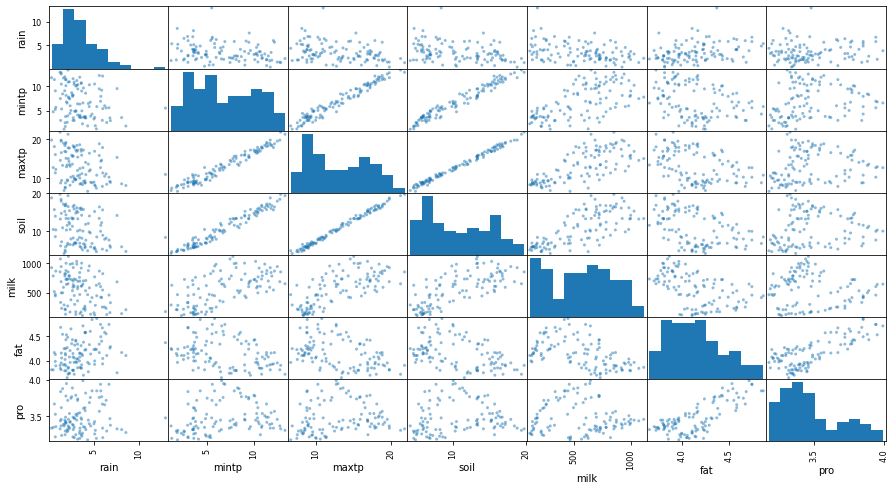

In [582]:
features = ['rain','mintp','maxtp','soil','milk','fat','pro']

scatter_matrix(iedw[features])
plt.savefig("scat_matrix_limited.png", dpi=300);
#plt.show()

In [518]:
# Need to total rain fall and average temp for each month

# and add to the milk production dataset
cw.head()

,date,ind,maxtp,ind.1,mintp,igmin,gmin,ind.2,rain,cbl,...,ind.5,hg,sun,dos,soil,pe,evap,smd_wd,smd_md,smd_pd
0,1962-01-01,0,2.8,1,-2.5,,,8,,999.6,...,0,24,,0,,,,,,
1,1962-01-02,0,2.8,1,-3.7,,,8,,1005.8,...,0,10,,0,,,,,,
2,1962-01-03,0,2.3,1,-3.8,,,8,,1007.8,...,0,13,,0,,,,,,
3,1962-01-04,0,6.6,0,0.6,,,8,,1007.8,...,0,12,,0,,,,,,
4,1962-01-05,0,9.3,0,0.6,,,8,,1002.2,...,0,29,,0,,,,,,


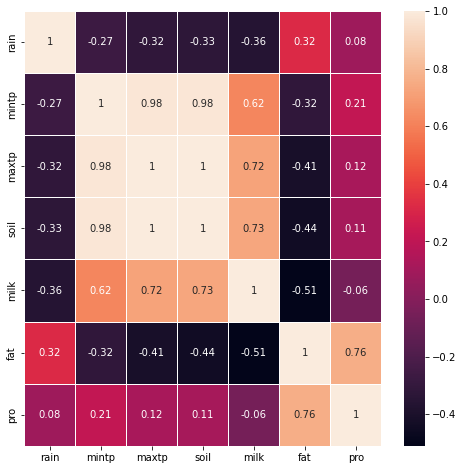

In [583]:
plt.figure(figsize=(8, 8))
cor_matrix = iedw.corr().round(2)
sns.heatmap(data = cor_matrix, annot=True,linewidths=.5)
plt.savefig("heatmap_1.png", dpi=300)
# We can see from the heat map there is a high corelation between soil temp and milk volums
# we also see there is a negative corelation between rain and milk production.
# interestingly fat and protine are positavly corelated with rain , but
# I can see from the graps in the statistics notebook fat and protine percentages are inversly proportional to 
# milk volums. So rain makes milk volums go down but protine and fat go up as a percentage on the lower volumes.

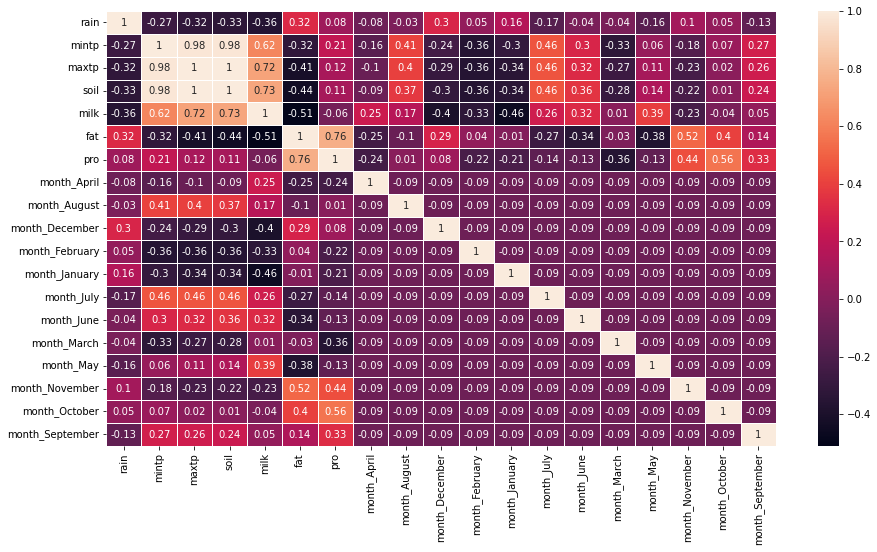

In [584]:
plt.figure(figsize=(15, 8))
cor_matrix = iedwd.corr().round(2)
sns.heatmap(data = cor_matrix, annot=True,linewidths=.5)
plt.savefig("heatmap_all_vars.png", dpi=300)
# after adding the months to the heat map , I still see soil temp is the top corelation.
# there is a pattern in the months that follows the serasons. summer months having tyhe highest positive 
# corolation and winter months having a negative corolation.
# this data agrees with the bos plots in the stastics note book.

# EDA on Danish Milk production
## With emphisis on fat and protine content of milk 
## by month

In [408]:
dkddf = pd.read_csv("DK_MILK3.csv",on_bad_lines='skip',skiprows=21,encoding = "ISO-8859-1")
dkddf.columns = ["date", "milk", "fat", "pro"]

In [31]:
dkddf.head()

,date,milk,fat,pro
0,1996M08,390.66,4.14,3.34
1,1996M09,370.08,4.25,3.45
2,1996M10,369.43,4.43,3.54
3,1996M11,351.61,4.49,3.55
4,1996M12,364.20,4.54,3.54


In [32]:
dkddf['date'] = dkddf['date'].apply(lambda x : x.replace('M',' '))

In [34]:
dkddf[["date"]] = dkddf[["date"]].apply(pd.to_datetime)

In [35]:
dkddf.head()

,date,milk,fat,pro
0,1996-08-01,390.66,4.14,3.34
1,1996-09-01,370.08,4.25,3.45
2,1996-10-01,369.43,4.43,3.54
3,1996-11-01,351.61,4.49,3.55
4,1996-12-01,364.20,4.54,3.54


In [39]:
dkddf = dkddf[(dkddf['date'] >= '2012-01-01')]
# Lambda string to extract month from date time object 
dkddf['month'] = dkddf['date'].apply(lambda x: x.strftime('%B')) 
dkddf.tail()

,date,milk,fat,pro,month
310,2022-06-01,477.21,4.17,3.52,June
311,2022-07-01,491.13,4.17,3.52,July
312,2022-08-01,481.27,4.18,3.53,August
313,2022-09-01,455.35,4.28,3.64,September
314,2022-10-01,461.00,4.40,3.72,October


In [40]:
dkddf.to_csv('DK_Milk_supply_Cleaned.csv')